In [1]:
import numpy as np
from scipy.stats import pearsonr
import scipy.signal as ss
import scipy.stats as scst
import saffy
from saffy.generators.svarog import svarog
import matplotlib.pyplot as plt
from scipy import signal
import mtmvar

In [2]:
saffy.__version__

'0.1.12-dev2'

In [3]:
fig = plt.figure(figsize = (50,20))

pliki = {'open':'mateusz_oczy_szeroko_zamkniete', 'closed':'mateusz_oczy_zamkniete', 'inne':'mateusz_try1'}

EEG2 = saffy.SignalManager(generator=svarog(pliki['closed']))
CH = ['Fp1', 'P3', 'Pz', 'P4', 'Fp2', 'O1', 'O2','A1','A2']
EEG2.butter_highpass_filter(cutoff=1, order=5, method=None)
EEG2.extract_channels(CH)
EEG_2D_F = EEG2.data[0,:,:] #jest tylko jeden zestaw danych
EEG_2D_F = EEG_2D_F - (EEG_2D_F[-1,:] + EEG_2D_F[-2,:])/2 #montaz - średnia z uszu   
EEG_2D_F = EEG_2D_F[0:-2,:] #usuwamy kanały uszne

2019-12-19 13:35:15,270 - data_source - INFO - All data set requested for the first time. Start reading all data from the file...


<Figure size 3600x1440 with 0 Axes>

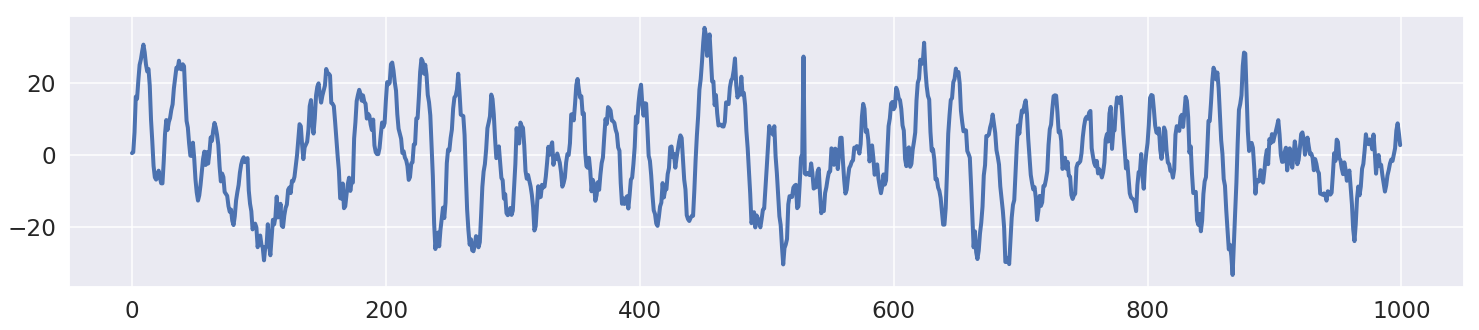

In [4]:
syg1 = EEG_2D_F[0,:1000]
fig = plt.figure(figsize = (25,5))
plt.plot(syg1, linewidth=4)
plt.show()

In [175]:
def widmo_AR(syg,p,Fs,step=Fs/2):
    if len(syg.shape) == 1:
        syg = np.reshape(syg,(1,-1))
    freqz = np.linspace(0, int(Fs/2),step)
    ch = syg.shape[0]
    A_all, V = mtmvar.mult_AR(syg, p, 1)
    S_all = np.zeros((len(freqz),ch,ch),dtype="complex")
    A = np.eye(ch)
    for ind,fr in enumerate(freqz):
        A_temp = np.zeros((p,A_all.shape[1],A_all.shape[2]),dtype="complex")
        for p_prim in range(p):
            z = np.exp(2*np.pi*1j*fr*1/Fs*(-(p_prim+1)))
            A_temp[p_prim] = A_all[p_prim]*z
        Az = A-np.sum(A_temp,axis=0)
        Az_inv = np.linalg.inv(Az)
        Hf = Az_inv
        Hfconj = np.conj(Hf).T
        S1 = np.dot(Hf,V)
        S2 = np.dot(S1,Hfconj)
        S_all[ind,:,:] = S2
    return freqz,S_all

In [118]:
def AIC(syg, min_order, max_order):
    if len(syg.shape) == 1:
        syg = np.reshape(syg,(1,-1))
    aic = np.zeros(max_order-min_order+1)
    k = syg.shape[0]
    N = syg.shape[1]
    for i, p in enumerate(range(min_order, max_order+1)):
        params, V = mtmvar.mult_AR(syg, p, 1)
        aic[i] = np.log(np.linalg.det(V)) + 2*p*k**2/N
    return aic

In [117]:
AR = []
for i in range(1,6):
    AR.append(mtmvar.mult_AR(syg1, i, 1))

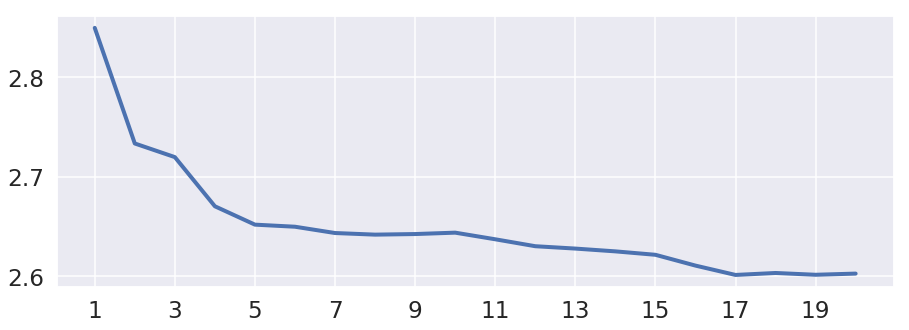

In [11]:
aic = AIC(syg1, 1, 20)
fig = plt.figure(figsize = (15,5))
plt.xticks(np.arange(1, 21, step=2))
plt.plot(np.arange(1,21), aic, linewidth=4)
plt.show()

### Ćwiczenie 2 - wykresy

In [ ]:
Signal = EEG_2D_F[:2,:1000]
p=17
ch = Signal.shape[0]
freqsy , S_Signal = widmo_AR(Signal,p,EEG2.fs)
plt.figure(figsize=(12,8))
for i in range(ch):
    for j in range(ch):
        plt.subplot(ch,ch,i*ch+j+1)
        if i == j:
            widmo = np.abs(np.fft.rfft(Signal[i]))
            freq = np.fft.rfftfreq(len(Signal[i]),1/EEG2.fs)
            plt.plot(freq,widmo,color = 'orange')
        plt.plot(S_Signal[:,i,j],color='k')
plt.show()

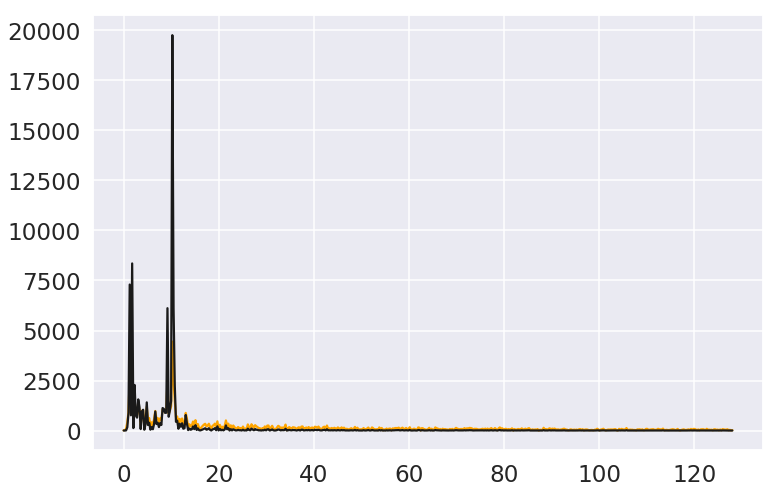

501 501
moc sygnału dla rfft: 88894.05 i dla AR: 82620.91


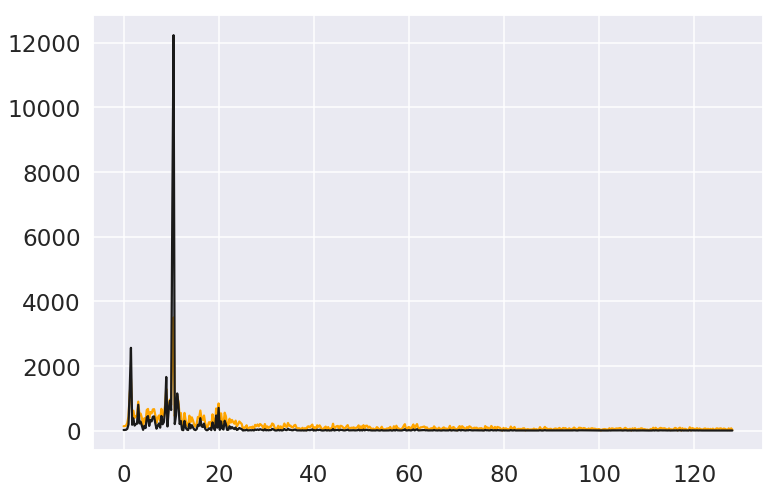

501 501
moc sygnału dla rfft: 75031.8 i dla AR: 46295.38


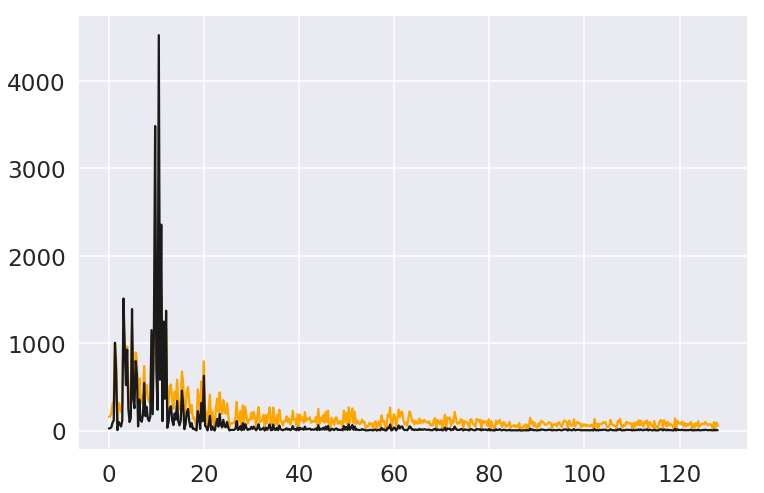

501 501
moc sygnału dla rfft: 84993.46 i dla AR: 40715.99


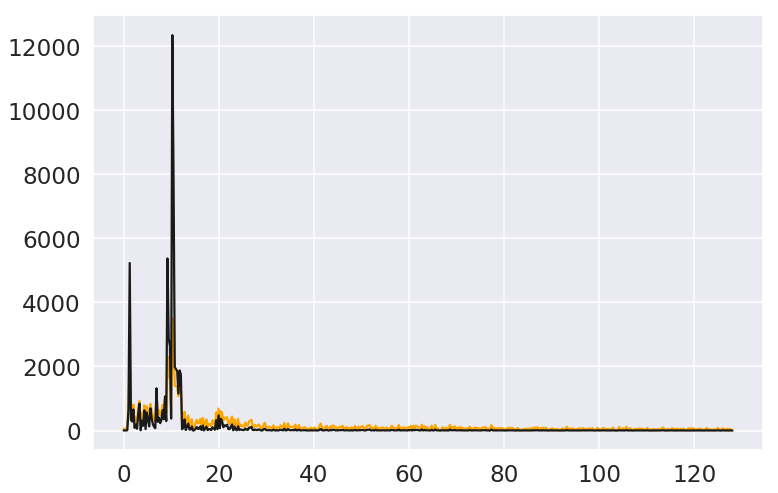

501 501
moc sygnału dla rfft: 83126.05 i dla AR: 67338.42


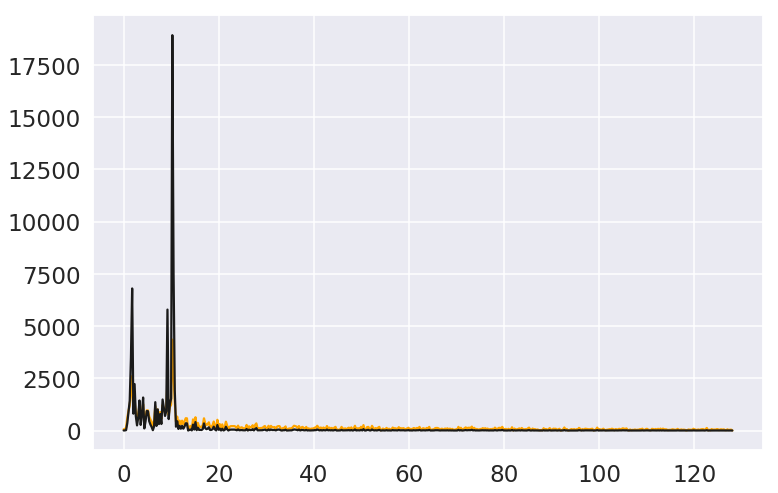

501 501
moc sygnału dla rfft: 91863.86 i dla AR: 80343.48


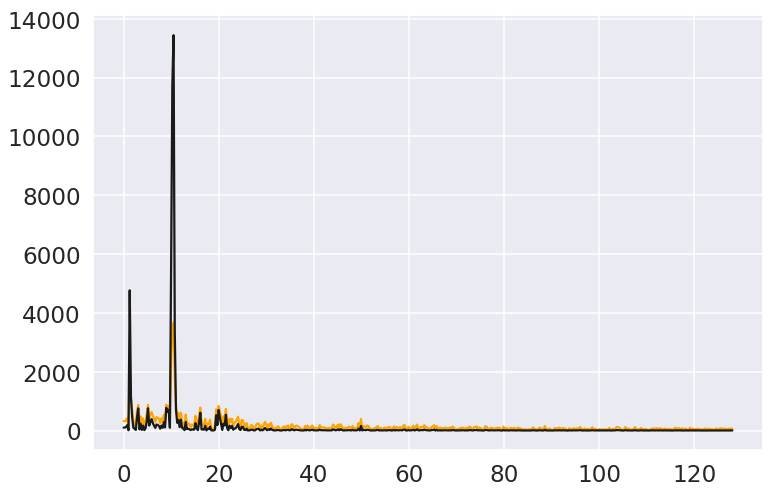

501 501
moc sygnału dla rfft: 81569.49 i dla AR: 61187.17


In [186]:
syg3 = EEG_2D_F[0:6,:1000]
freq = np.fft.rfftfreq(len(syg3[0]),1/EEG2.fs)
p = 250
ch = syg3.shape[0]
freqs,S_syg3 = widmo_AR(syg3,p,EEG2.fs,len(freq))
S_syg3 = np.abs(S_syg3)
for i in range(ch):
    plt.figure(figsize=(12,8))
    widmo = np.abs(np.fft.rfft(syg3[i]))
    freq = np.fft.rfftfreq(len(syg3[i]),1/EEG2.fs)
    plt.plot(freq,widmo,color = 'orange')
    plt.plot(freqs,S_syg3[:,i,i],color='k')
    plt.show()
    print(len(freq), len(freqs))
    print(f'moc sygnału dla rfft: {round(np.sum(widmo),2)} i dla AR: {round(np.sum(S_syg3[:,i,i]),2)}')

# plt.show()

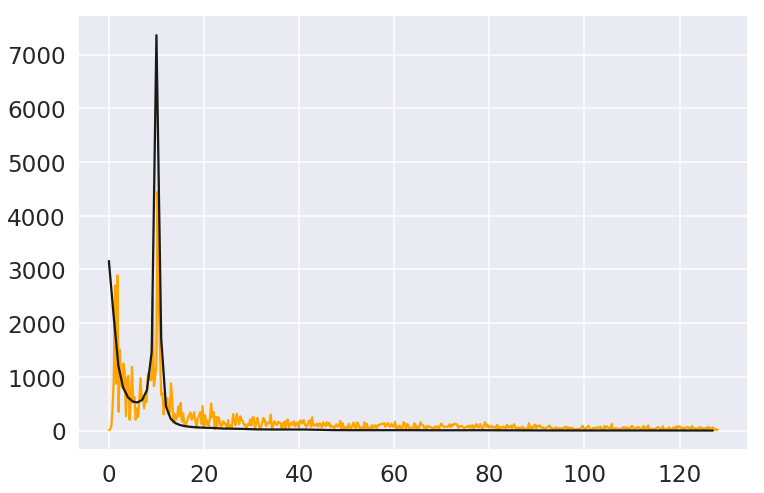

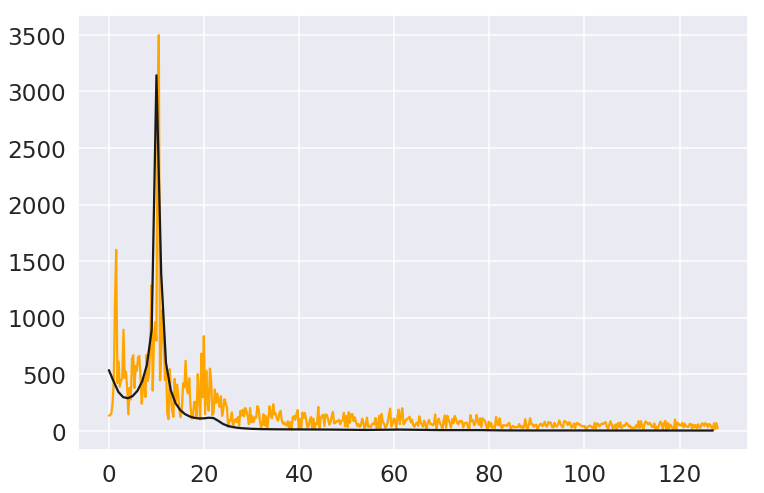

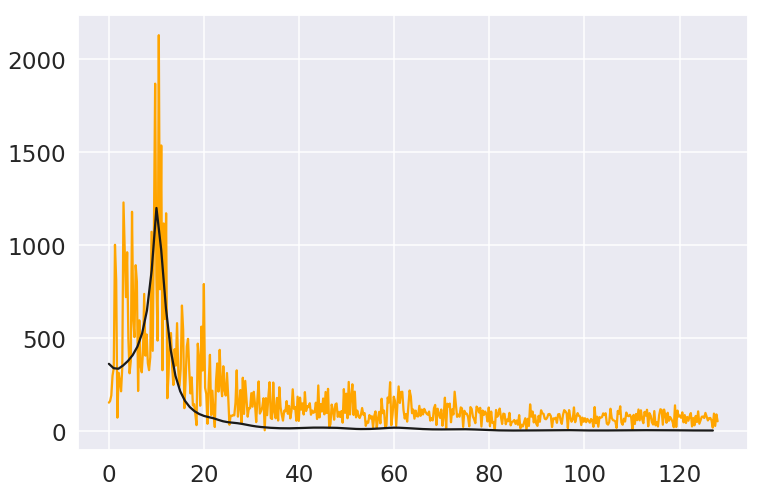

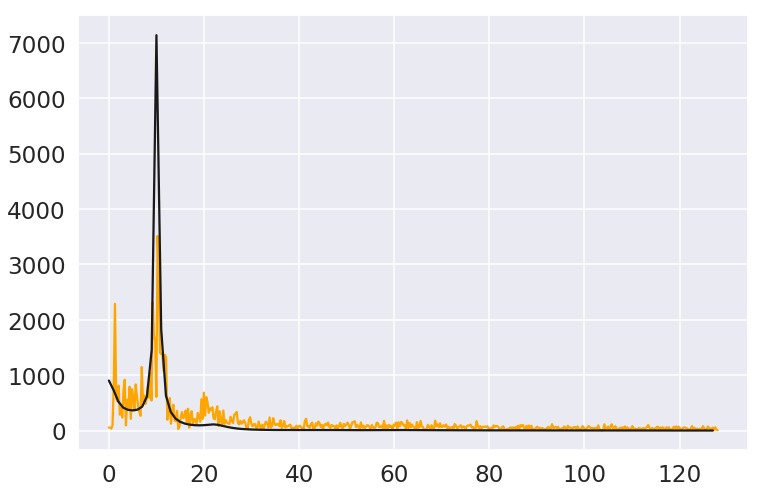

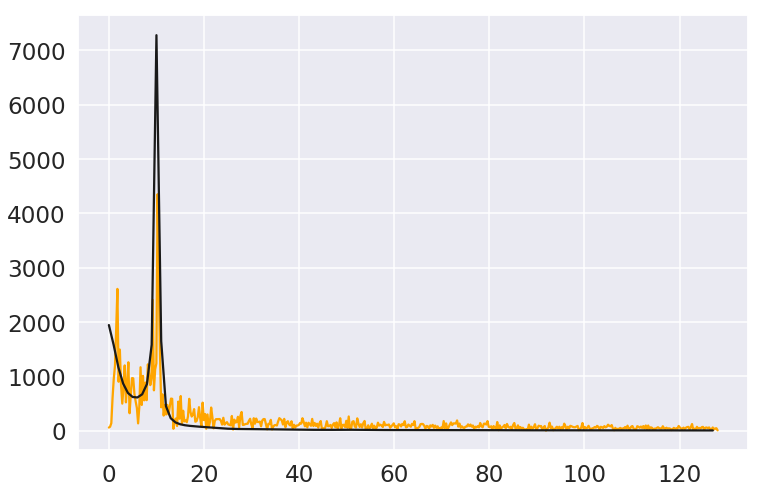

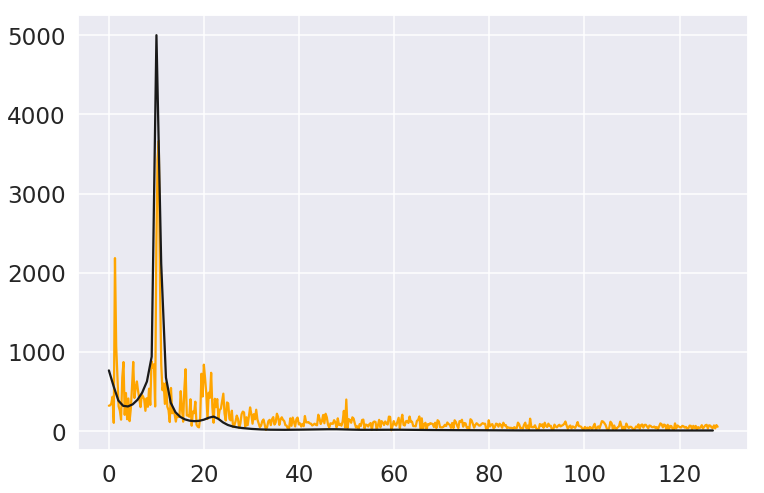

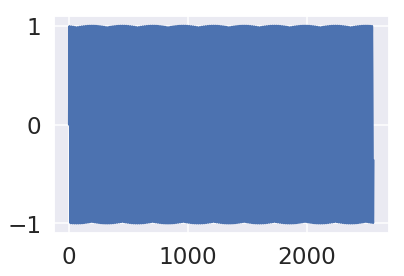

(1, 2560)

In [62]:
T=10
Fs=256
t = np.arange(0,T,1/Fs)
f = 15
sinus = np.sin(2*np.pi*f*t)
plt.plot(sinus)
plt.show()
sinus = np.reshape(sinus,(1,-1))
sinus.shape

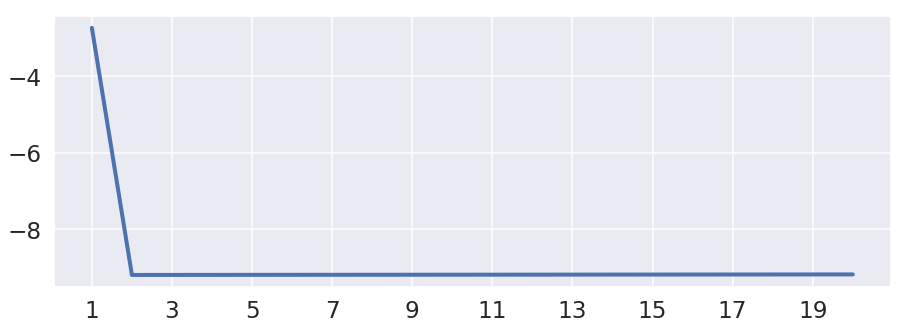

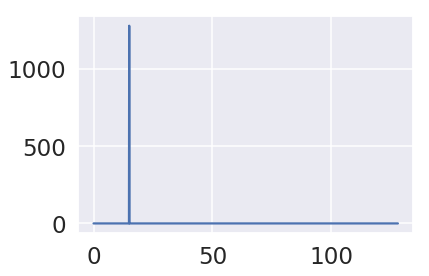

In [63]:
aic = AIC(sinus,1,20)
fig = plt.figure(figsize = (15,5))
plt.xticks(np.arange(1, 21, step=2))
plt.plot(np.arange(1,21), aic, linewidth=4)
plt.show()
widmo = np.abs(np.fft.rfft(sinus[0]))
freq = np.fft.rfftfreq(len(sinus[0]),1/EEG2.fs)
plt.plot(freq,widmo)
# plt.xlim
plt.show()

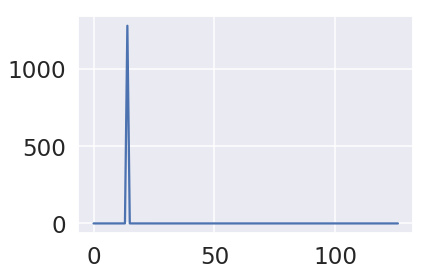

In [132]:
p=2
ch=1
S_sinus = widmo_AR(sinus,p,Fs)
for i in range(ch):
    plt.plot(S_sinus[:,i,i])
plt.show()

In [213]:
f = np.arange(1, int(EEG2.fs/2))
p=5
A, V = mtmvar.mult_AR(syg3, p, 1)

oczko = np.eye(A.shape[1])
A_temp = np.zeros((A.shape[0]+1,A.shape[1],A.shape[2]))
A_temp[1,:,:] = oczko
A_temp[1:,:,:] = -A
A = A_temp
# print(A.shape)
# print(oczko.shape)
z = np.exp(2*np.pi*1j*f*(1/EEG2.fs))**np.arange(0,-p-1,-1).reshape((-1,1,1))
# print(z.shape)
# z = np.squeeze(z).reshape((z.shape[-1],z.shape[0]))
z = np.squeeze(z).T
# print(z.shape , A.shape)
Az = np.tensordot(z , A , axes=1)

Az = np.swapaxes(Az, 0, 2)
Az = np.swapaxes(Az, 0, 1)
# print(Az.shape)
# Az = np.reshape(Az,(Az.shape[-1],Az.shape[1],Az.shape[0]))
H = np.linalg.inv(Az.T).T
# print(H.shape)
# H = np.reshape(H,(H.shape[-1],H.shape[1],H.shape[0]))
# print(H.shape)
H = np.swapaxes(H, 0, 1)
H = np.swapaxes(H, 0, 2)
print(H.shape)
Hconj = np.conj(H).swapaxes(1,2)

Hconj = np.swapaxes(Hconj, 0, 1)

Hconj = np.swapaxes(Hconj, 1, 2)
print(Hconj.shape)
S = np.tensordot(Hconj , H , axes=2)
print(S.shape)
for i in range(3):
    plt.plot(S[:,i,i])
plt.show()

widmo = np.abs(np.fft.rfft(syg3[0]))
freq = np.fft.rfftfreq(len(syg3[0]),1/EEG2.fs)
plt.plot(freq,widmo)
# plt.xlim
plt.show()

(127, 6, 6)
(6, 6, 127)


ValueError: shape-mismatch for sum